In [75]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [76]:
#数据下载位置：
#https://github.com/CSSEGISandData/COVID-19/tree/master/
df = pd.read_csv('time_series_covid19_confirmed_global.csv')

In [77]:
df = df.iloc[:, 4:-12]

In [78]:
df.isnull().sum().sum()

0

In [79]:
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

2020-01-22     555
2020-01-23     654
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
dtype: int64

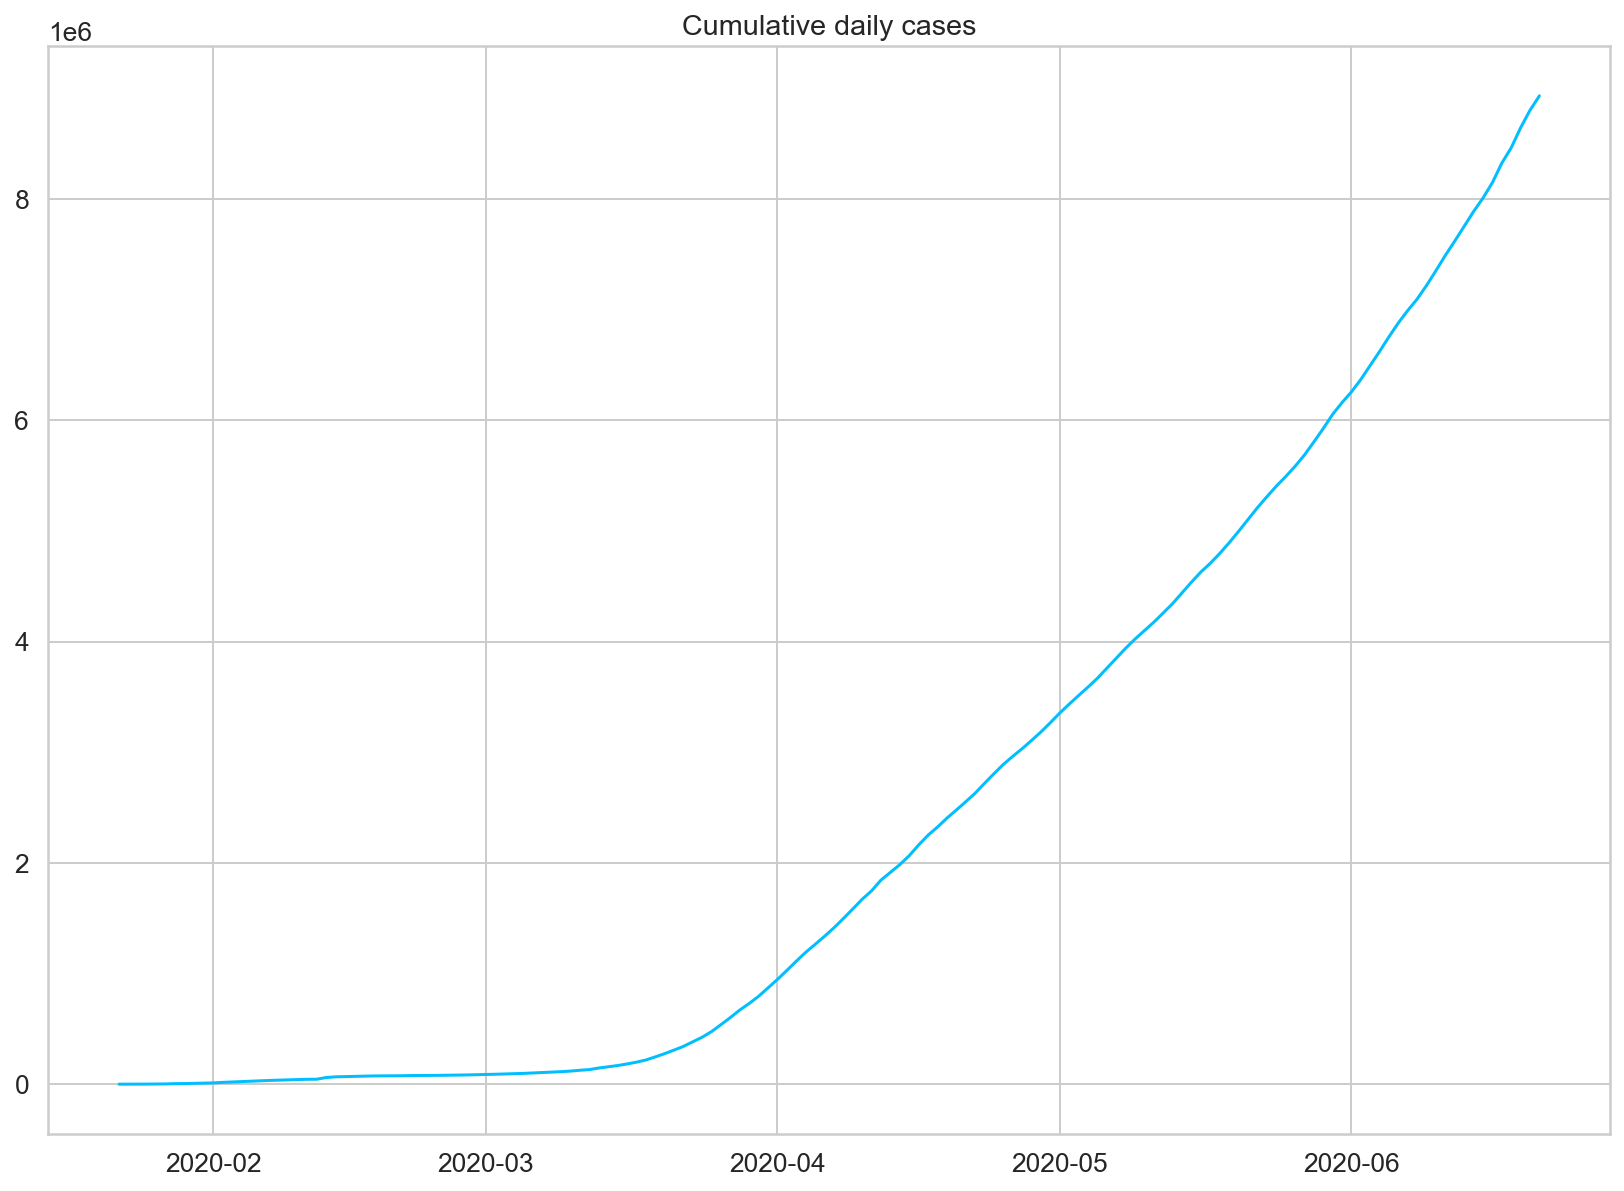

In [80]:
plt.plot(daily_cases)
plt.title("Cumulative daily cases");

In [81]:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

2020-01-22    555
2020-01-23     99
2020-01-24    287
2020-01-25    493
2020-01-26    684
dtype: int64

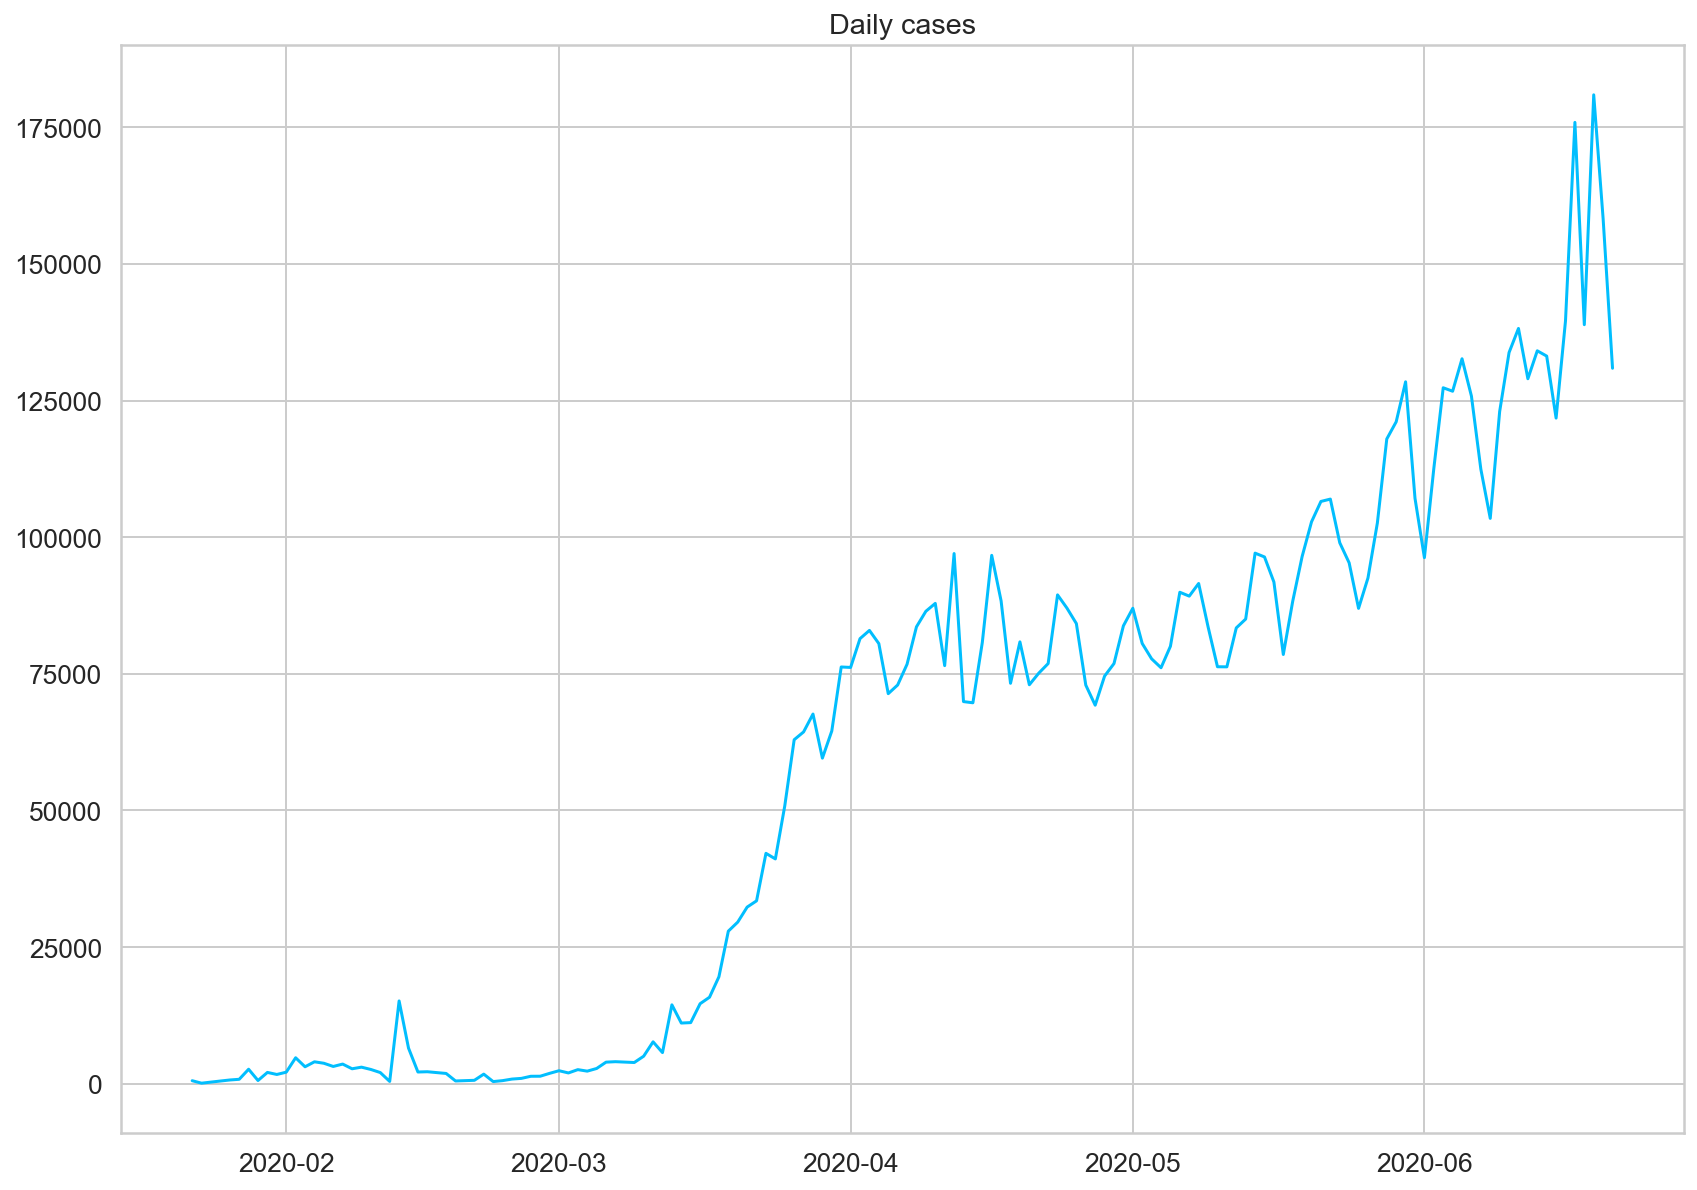

In [82]:
plt.plot(daily_cases)
plt.title("Daily cases");

In [83]:
daily_cases.shape

(152,)

In [84]:
#preprocessing
test_data_size = 28
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
train_data.shape

(124,)

In [85]:
#Scale data
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(train_data, axis=1))
train_data = scaler.transform(np.expand_dims(train_data, axis=1))
test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [86]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [87]:
X_train.shape

torch.Size([118, 5, 1])

In [88]:
X_train[:2]

tensor([[[0.0043],
         [0.0000],
         [0.0018],
         [0.0037],
         [0.0055]],

        [[0.0000],
         [0.0018],
         [0.0037],
         [0.0055],
         [0.0066]]])

In [89]:
y_train.shape

torch.Size([118, 1])

In [90]:

y_train[:2]

tensor([[0.0066],
        [0.0239]])

In [91]:
#Build Model
class CoronaVirusPredictor(nn.Module):
  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()
    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers
    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.2
    )
    self.linear = nn.Linear(in_features=n_hidden, out_features=1)
  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )
  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [92]:
#Training
def train_model(
  model,
  train_data,
  train_labels,
  test_data=None,
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')
  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 60
  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)
  for t in range(num_epochs):
    model.reset_hidden_state()
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(), y_train)
    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()
      if t % 10 == 0:
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')
    train_hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
  return model.eval(), train_hist, test_hist

In [93]:
#Run the training
model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model,
  X_train,
  y_train,
  X_test,
  y_test
)

Epoch 0 train loss: 34.68980026245117 test loss: 32.999305725097656
Epoch 10 train loss: 19.42357063293457 test loss: 21.82620620727539
Epoch 20 train loss: 15.692694664001465 test loss: 10.927464485168457
Epoch 30 train loss: 15.257588386535645 test loss: 14.599265098571777
Epoch 40 train loss: 15.01971435546875 test loss: 12.119447708129883
Epoch 50 train loss: 14.742729187011719 test loss: 11.569415092468262


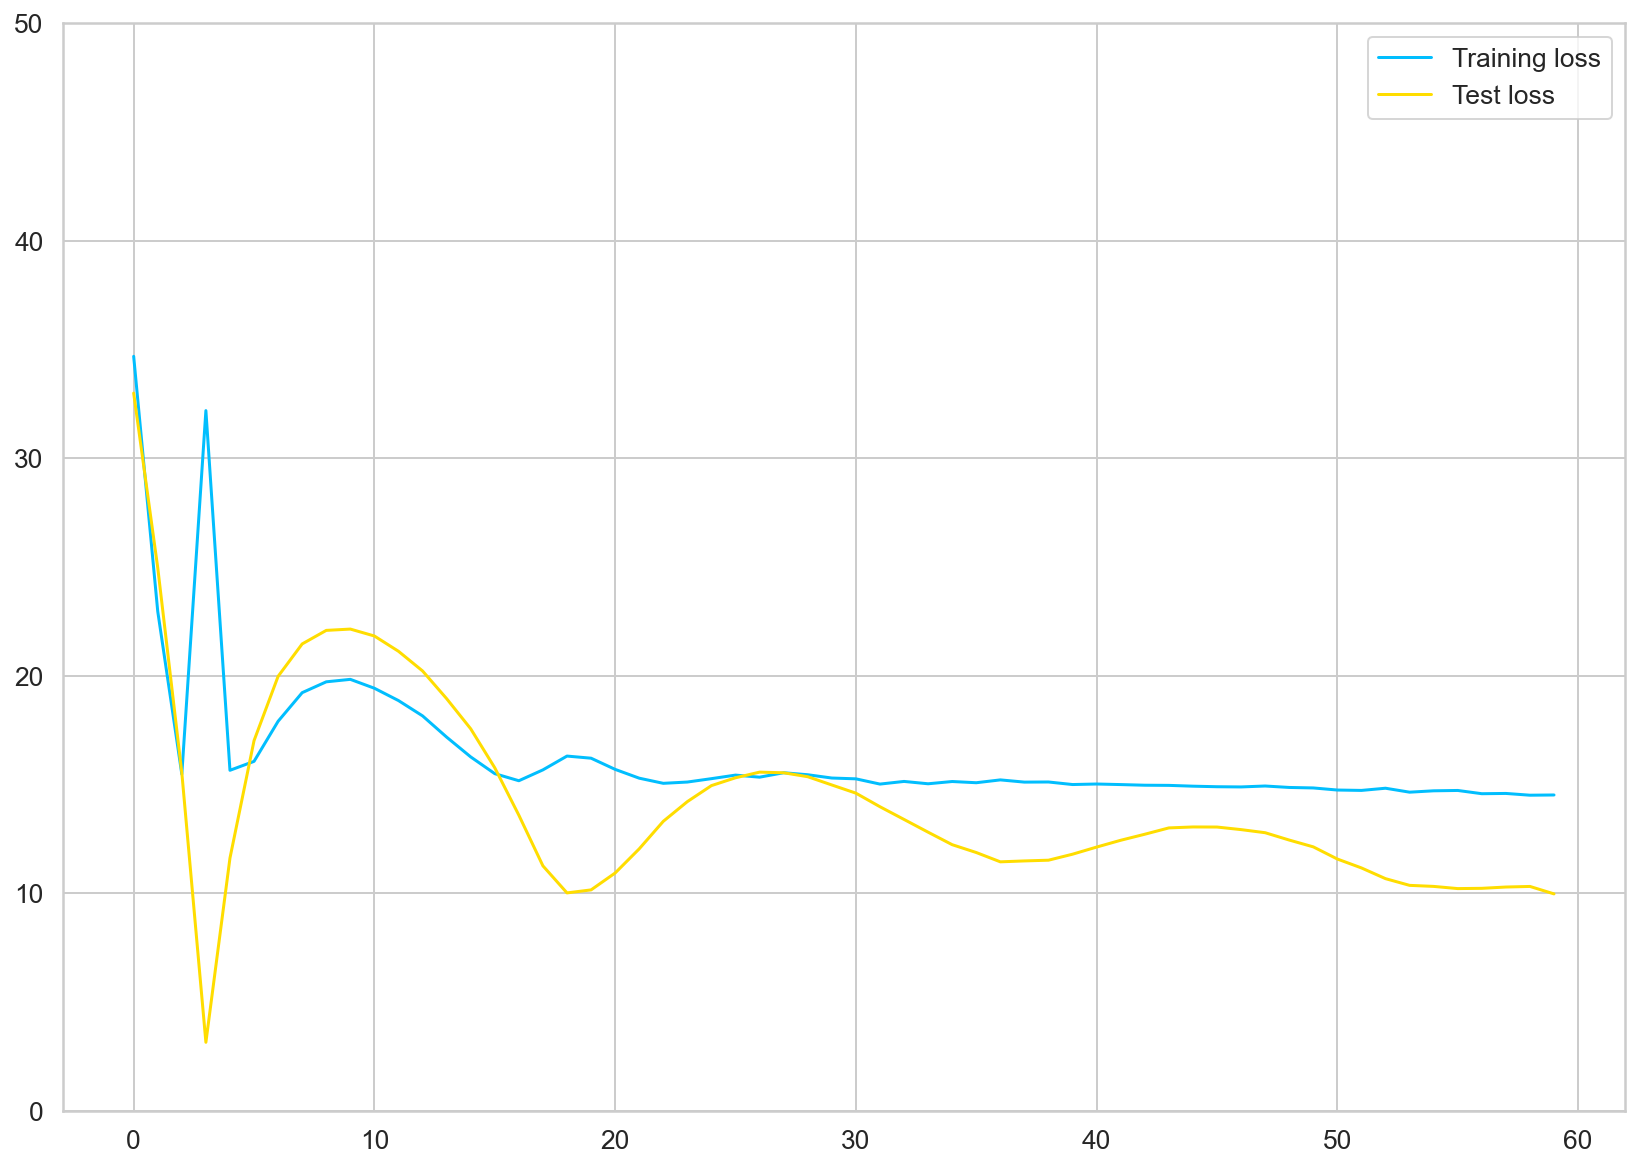

In [94]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0,50))
plt.legend();
#results are not quite good. We can try more data

In [95]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [96]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

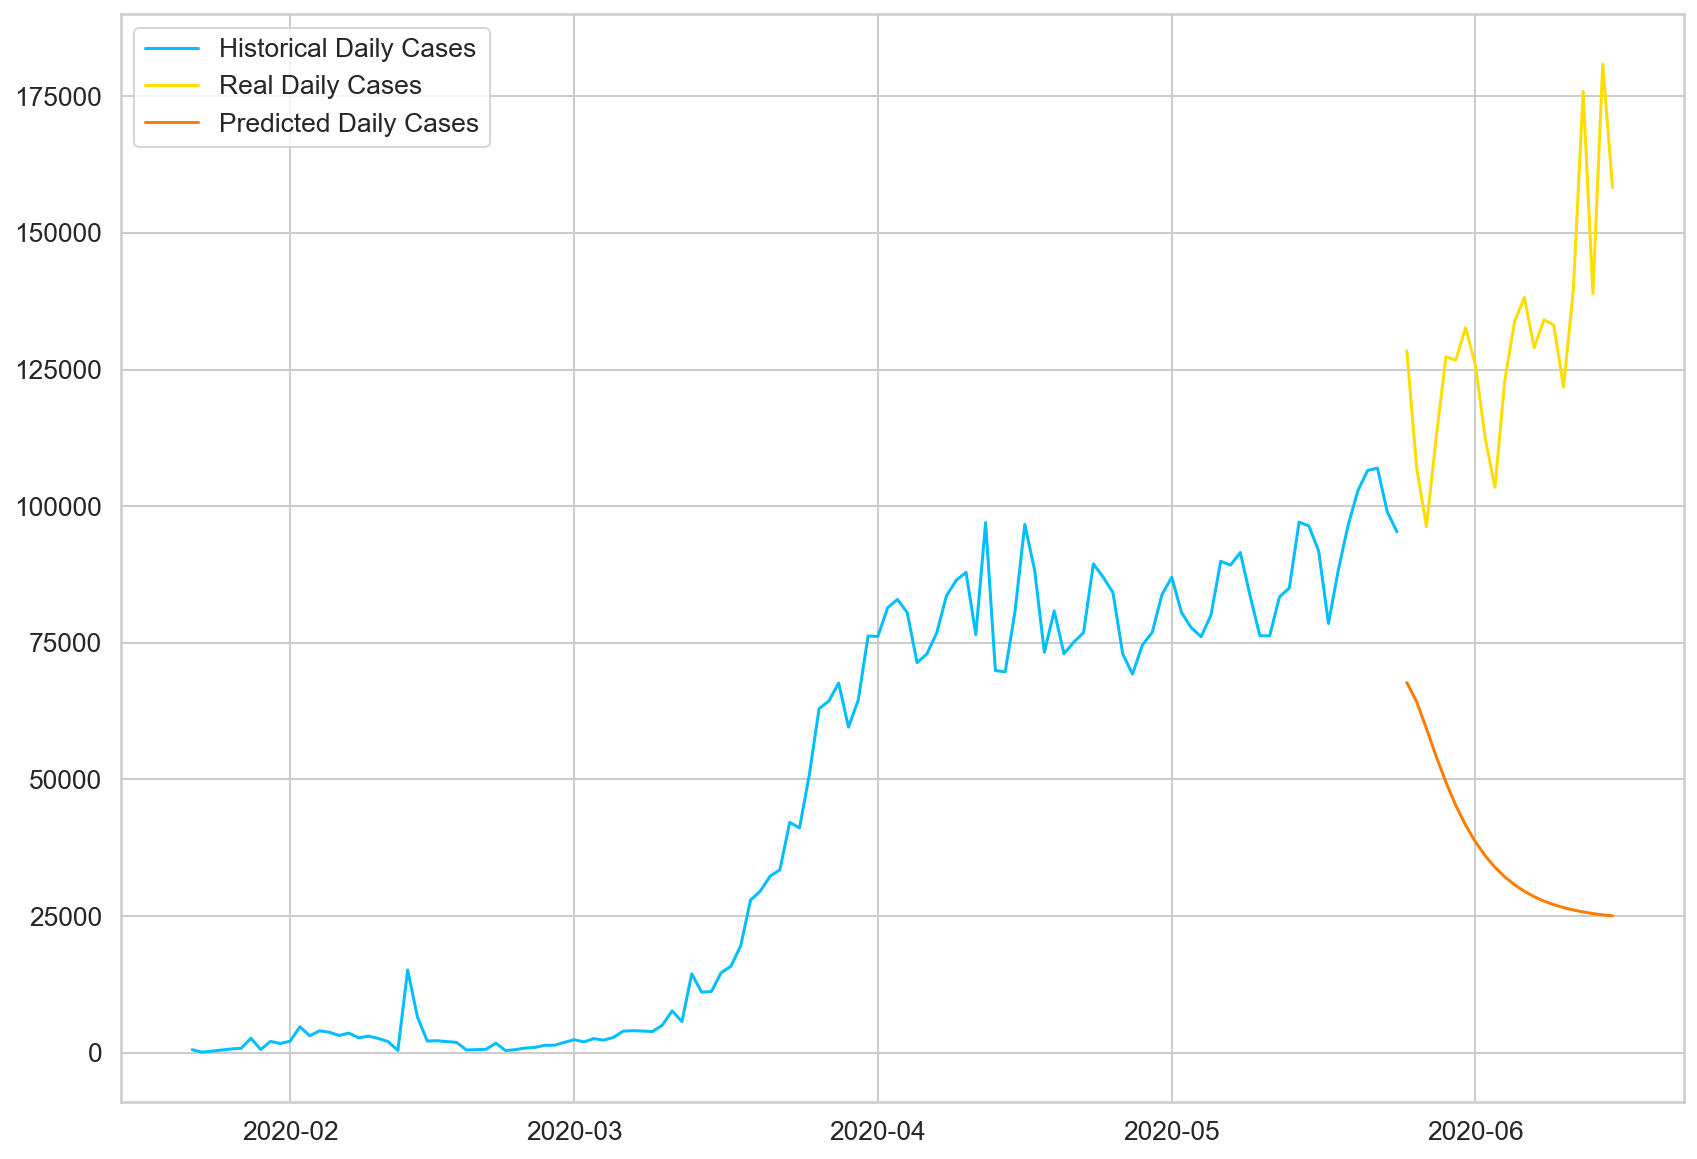

In [97]:
plt.plot(
  daily_cases.index[:len(train_data)],
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Cases'
)
plt.legend();

In [98]:
#使用更多数据

In [99]:
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))
all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))
all_data.shape

(152, 1)

In [100]:
X_all, y_all = create_sequences(all_data, seq_length)
X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()
model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 38.10619354248047
Epoch 10 train loss: 21.353225708007812
Epoch 20 train loss: 15.576343536376953
Epoch 30 train loss: 15.097801208496094
Epoch 40 train loss: 14.978292465209961
Epoch 50 train loss: 14.795960426330566


In [101]:
DAYS_TO_PREDICT = 12
with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [102]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

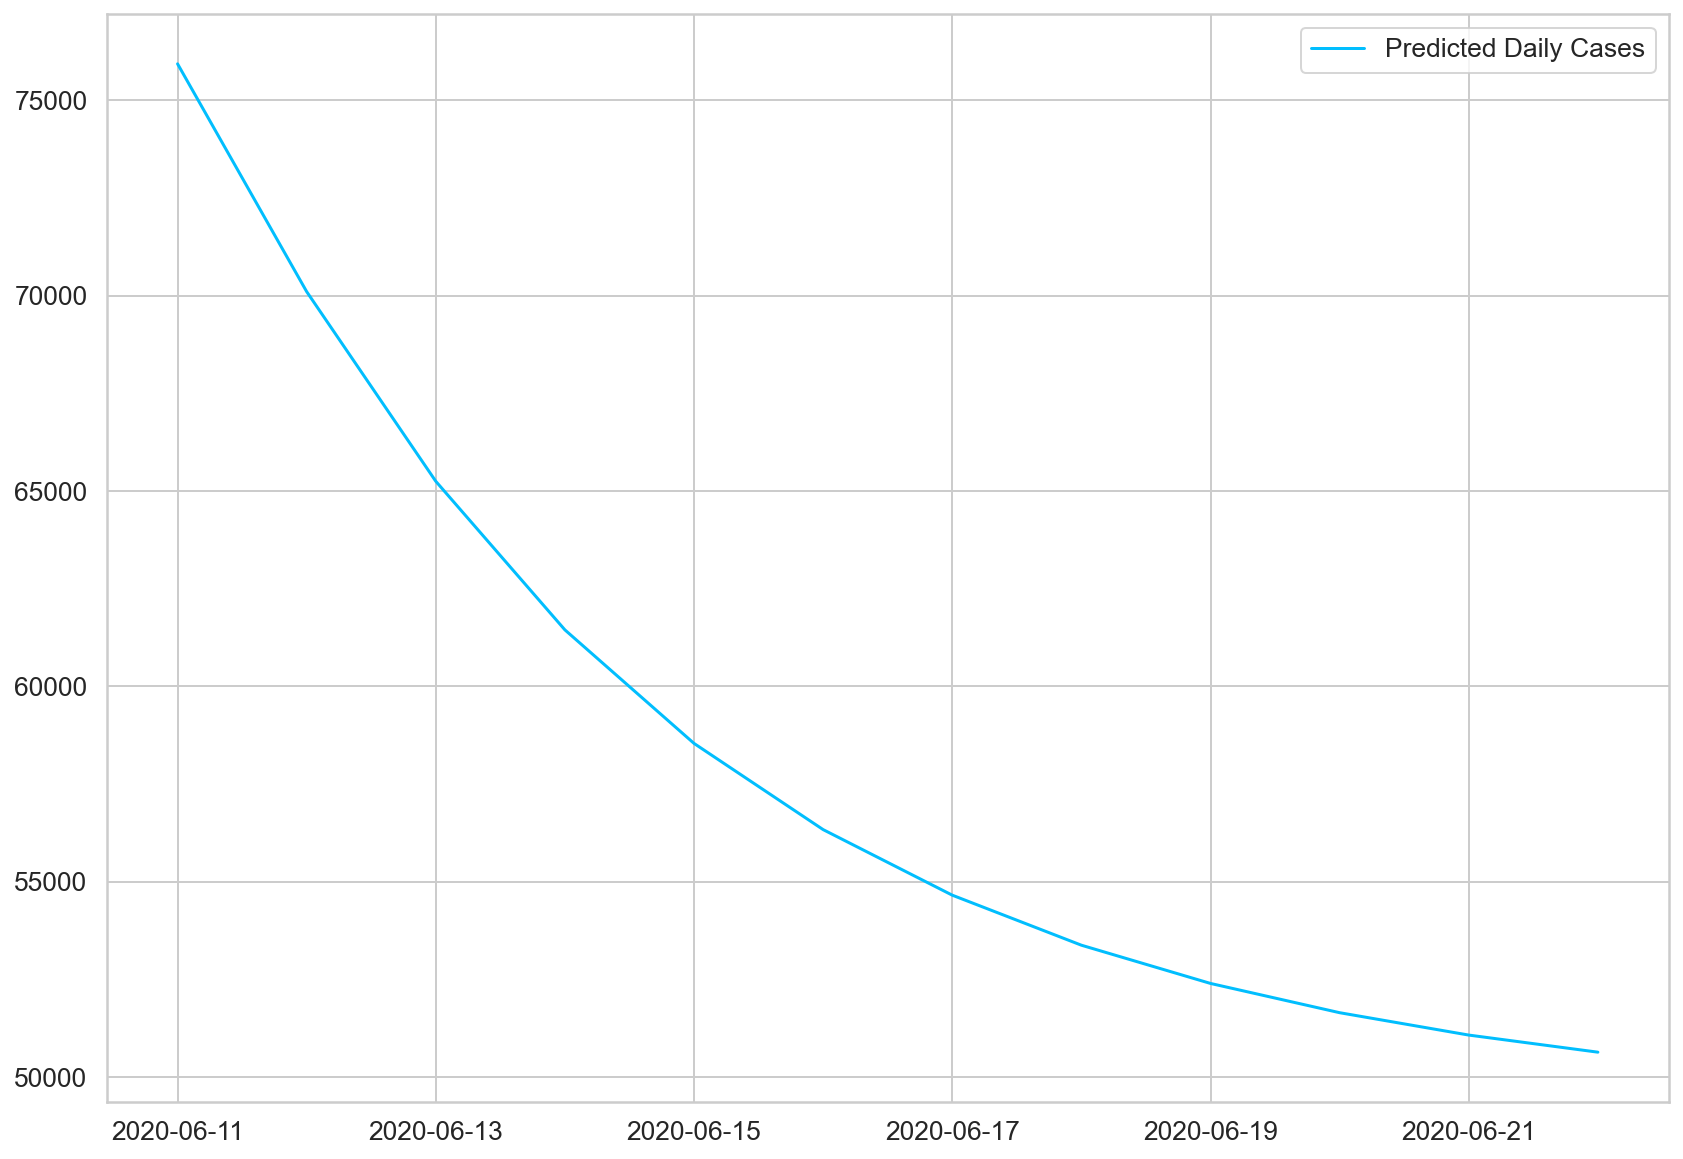

In [103]:
daily_cases.index[-12]

predicted_index = pd.date_range(
  start=daily_cases.index[-12],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)
predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

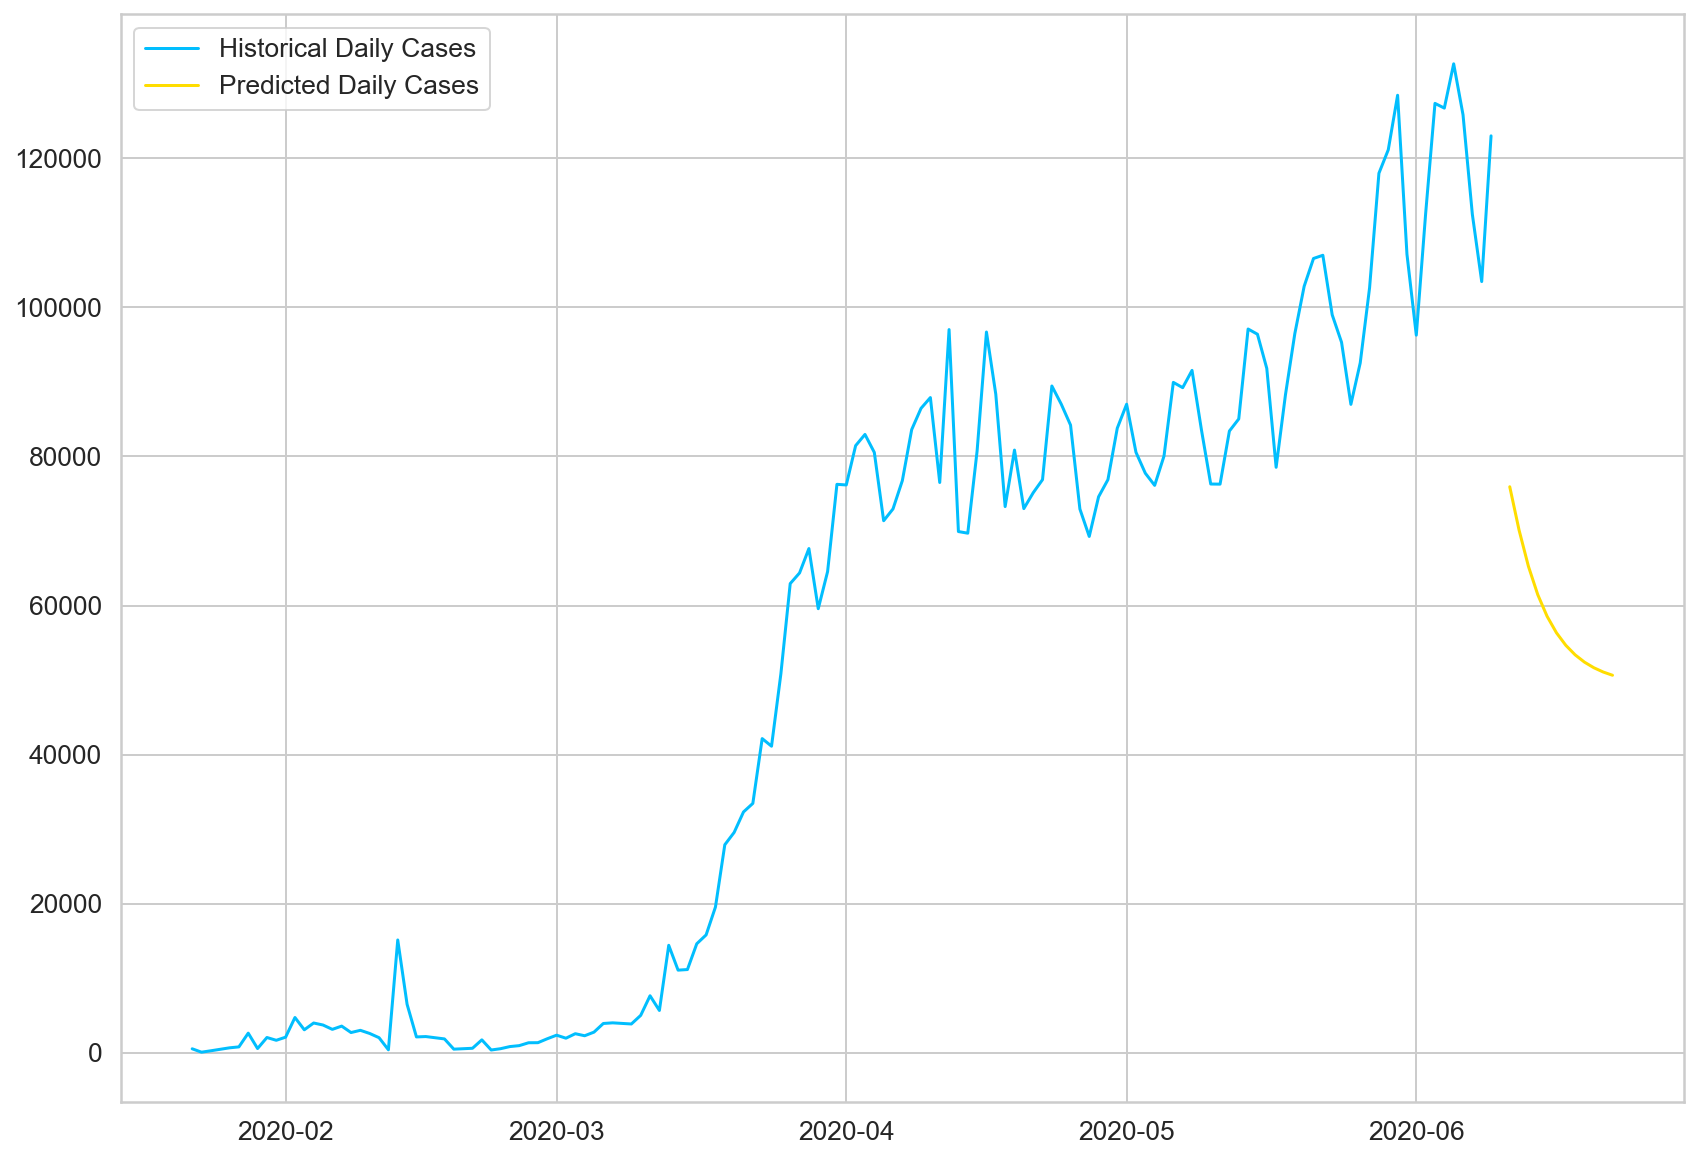

In [104]:
plt.plot(daily_cases[0:-12], label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();